# Проект по временным рядам

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Исходные данные:** исторические данные о заказах такси в аэропортах.

**Цель работы:** спрогнозировать количество заказов на следующий час. При этом значение метрики *RMSE* на тестовой выборке должно быть не больше 48.


## Подготовка

In [1]:
#используемые библиотеки
import pandas as pd

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Загрузим необходимые нам данные, проверим их формат.

In [2]:
from io import BytesIO
import requests
spreadsheet_id = '*имя файла*'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
data = pd.read_csv(BytesIO(r.content), index_col=[0], parse_dates=[0])
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Для дальнейшего построения графика дублируем данные в переменную _data_rolling_.

In [3]:
data_rolling = pd.read_csv(BytesIO(r.content), index_col=[0], parse_dates=[0])

data.info()
print()
data_rolling.info()
display(data_rolling.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


**Вывод**

Пропущенных значений в данных нет, тип данных корректен.

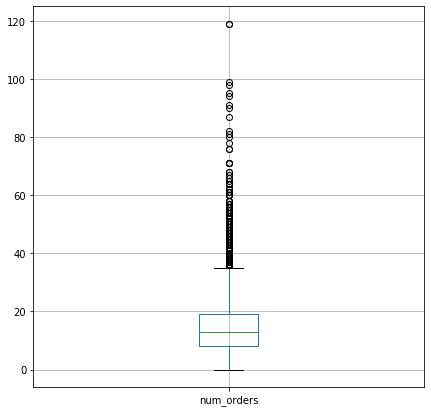

In [4]:
#проверка значений на адекватность
data.boxplot(figsize=(7,7))

С помощью боксплота проверяем данные на возможные вбросы или неадекватные значения. Согласно диаграмме вбросов достаточно много, но они находятся в разумных пределах (100 заказов такси в час в аэропорту - вполне реально). Значение 120 заказов/час проверим отдельно.

In [5]:
print(data.query('num_orders>100'))

                     num_orders
datetime                       
2018-08-13 02:20:00         119
2018-08-27 02:10:00         119


Посмотрим когда именно было совершено самое большое количество заказов. Оба показателя это два часа ночи, когда общественный транспорт уже не ходит. Оставим эти значения в выборке.

In [6]:
#ресемплирование
data.sort_index(inplace=True)
data = data.resample('1H').sum()

Так как прогноз необходимо делать на час вперед, то и ресемплирование сдедаем на час.

## Анализ

Построим тред и проанализируем его.

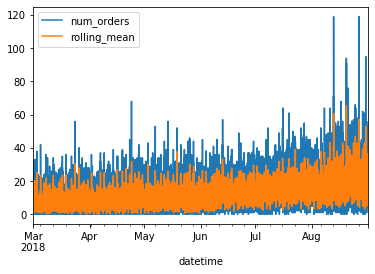

In [7]:
data_rolling['rolling_mean'] = data_rolling.rolling(10).mean()
data_rolling.plot()

**Вывод**

1. Масштаб графика слишком большой, чтобы можно было сделать конкретные выводы по тренду или скользящему среднему. 

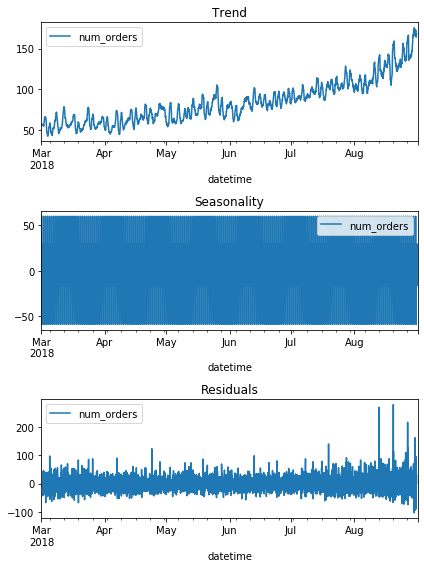

In [8]:
#вычисление трендов и сезонности

decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Вывод**
1. Тренд показывает нам постепенный прирост заказов такси к осени.
2. Очевидно, что масштаб графика для отображения сезонности слишком большой. Попробуем посмотреть в течении недели или суток.


Text(0.5, 1.0, 'Seasonality')

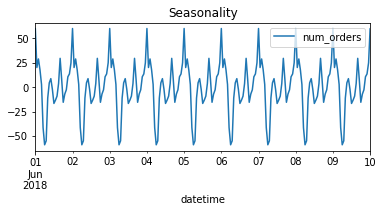

In [9]:
#более крупный масштаб для сезонности

plt.figure(figsize=(6, 8))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), xlim=(['2018-06-01' , '2018-06-10']))
plt.title('Seasonality')

**Вывод**
1. Для наблюдения за сезонностью был выбран период в 10 дней. На графике видно четкую повторяющуюся закономерность. Увеличим масштаб до суток, чтобы понять на какое время приходится пиковая активность.
2. Для того, чтобы анализ был более полным рассмотрим сезонность в будний день и в выходной

Text(0.5, 1.0, 'Seasonality')

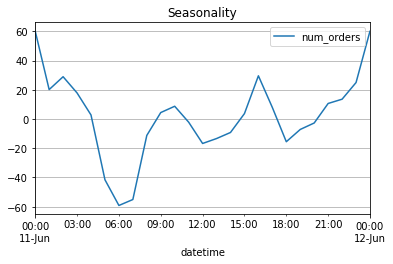

In [10]:
#сезонность для буднего дня

plt.figure(figsize=(6, 12))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), xlim=(['2018-06-11' , '2018-06-12']), grid=True)
plt.title('Seasonality')

Text(0.5, 1.0, 'Seasonality')

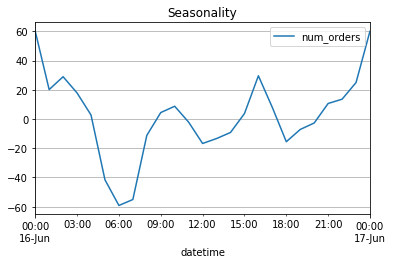

In [11]:
#сезонность для выходного дня

plt.figure(figsize=(6, 12))
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), xlim=(['2018-06-16' , '2018-06-17']), grid=True)
plt.title('Seasonality')

**Вывод**
1. Графики вызова такси в будний и выходной день очень похожи, поэтому будет рассматривать только один из них. Возьмем первый график.
2. Пиковая активность такси приходится на полночь. Скорей всего это связано с тем, что общественный транспорт перестает работать в это время. Также пики активности наблюдаются около 18:00 и 11:00.
3. Минимум активности - утро (06:00).

## Обучение модели

При работе с временными рядами необходимо создать ряд новых признаков, по которым будет идти обучение. Для этого введем новые переменные: день недели, скользящее среднее и отстающие значения.

В качестве календарного значения оставим день недели, так как требуемое предсказание всего на 1 час, остальные данные (число, месяц) не потребуются.

In [12]:
#выделение признаков
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(data, 30, 10)
display(data.head())

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Делим данные на тестовую и обучающие выборки для проведения математического моделирования.

In [13]:
#разделение данных
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

Делим данные на тестовую и обучающие выборки для проведения математического моделирования.

In [14]:
#выделение признаков и целевого признака
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
                        
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Сперва возьмем для обучения простые модели и посмотрим на результат. Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [15]:
#модель линейной регрессии
model = LinearRegression()
model.fit(features_train, target_train) 
predictions_train = model.predict(features_train) 

mse = mean_squared_error(target_train, predictions_train)
rsme = mse**0.5
print('RSME для модели линейной регрессии:', rsme)

RSME для модели линейной регрессии: 25.578383551979595


In [16]:
#модель случайного леса
model_forest = RandomForestRegressor(random_state=12345, n_estimators=50, max_depth=20)
model_forest.fit(features_train, target_train) 
predictions_train = model_forest.predict(features_train)

mse_forest = mean_squared_error(target_train, predictions_train)
rsme_forest = mse_forest**0.5
print('RSME для модели случайного леса:', rsme_forest)

RSME для модели случайного леса: 8.909071638439013


**Вывод**
1. На данном этапе лучший результат дает модель случайного леса (RMSE=8.91)

## Тестирование

Проверим лучшие модели на тестовой выборке 

In [17]:
#тест линейной регрессии

predictions_test = model.predict(features_test) 

mse_test = mean_squared_error(target_test, predictions_test)
rsme_test = mse_test**0.5
print('RSME для модели линейной регрессии:', rsme_test)

RSME для модели линейной регрессии: 45.0986095181678


In [18]:
#тест случайного леса

predictions_test_forest = model_forest.predict(features_test)

mse_forest_test = mean_squared_error(target_test, predictions_test_forest)
rsme_forest_test = mse_forest_test**0.5
print('RSME для модели случайного леса:', rsme_forest_test)

RSME для модели случайного леса: 43.14601272183152


**Вывод**
1. На тестовой выборке лучшей моделью является модель случайного леса с RMSE=43.49

In [19]:
#график предсказаний/реальных данных
predictions = pd.Series(data=predictions_test_forest, name='predictions')

test = test.reset_index()

test = test.join(predictions)

Для визуализации полученных результатов построим график 

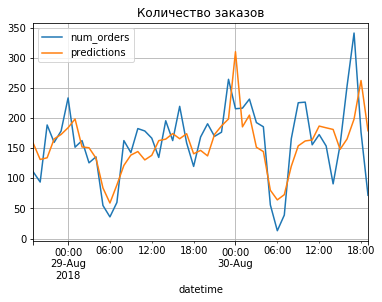

In [20]:
test_plot = test.loc[365:413]

ax=test_plot.plot('datetime', 'num_orders', legend=True, grid=True, title='Количество заказов')

test_plot.plot('datetime', 'predictions', legend=True, grid=True, title='Количество заказов', ax=ax)

На графике видно, что линия предсказаний хорошо отмечает пиковые значения заказов. Значит, с помощью данной модели можно понять, когда потребуется больше водителей, а когда меньше.

## Выводы

- В ходе проведенной работы была разработана модель, которая способна предсказывать заказы такси на следующий час с точностью на тестовой выборке RMSE=43.49. 

- Модель построена на основе алгоритма случайный лес. 

- Для создания признаков, необходимых для обучения, испольльзовался метод "отстающих значений", также календарные признаки были выделены отдельно. 

